In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
np.random.seed(123)  # For reproducibility

In [3]:
print(torch.__version__)

1.10.2


In [4]:
annotation = pd.read_csv("Data/annotations.csv")

In [5]:
annotation

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115,rbc
2336,image-69.png,201.832018,211.930101,251.736189,256.000000,rbc
2337,image-69.png,81.188275,231.883878,130.855693,254.391206,rbc
2338,image-69.png,35.903044,244.555806,79.863585,255.066516,rbc


In [6]:
images = annotation.image.unique()

In [7]:
# Number of unique training images
annotation['image'].nunique()

100

In [8]:
train_images = images[:80]
test_images = images[80:]

In [9]:
import os
working_dir = '/User/ccclaire/Desktop/Intern Assessment'
train_dir = os.path.join(working_dir, 'train')
test_dir = os.path.join(working_dir, 'test')

In [10]:
yolo_train_dir = "yolo/train"
yolo_test_dir = "yolo/test"

In [11]:
for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo/train/images
yolo/train/labels
yolo/test/images
yolo/test/labels


In [12]:
import glob
from tqdm import tqdm
import os
import cv2

(256, 256, 3)


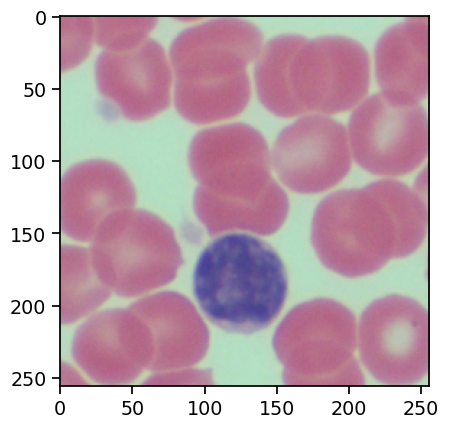

In [13]:
# read a single image (image-100 as example)
image = cv2.imread('Data/images/image-100.png')
image = image[:,:,2::-1]
print(image.shape)
plt.imshow(image)
plt.show()

In [14]:
WIDTH = 256
HEIGHT = 256
cells_id = {'rbc': 0,'wbc': 1}

In [15]:
cells_classes = list(cells_id.keys())
cells_classes

['rbc', 'wbc']

In [16]:
# Number of classes
annotation['label'].value_counts()

rbc    2237
wbc     103
Name: label, dtype: int64

In [17]:
for image in train_images:
    lables_file = os.path.join(yolo_train_dir, 'labels', image.replace(".png", ".txt"))
    with open(lables_file, "w") as wobj:
        for box in annotation.loc[annotation.image == image].values:
            wobj.write("%d %f %f %f %f \n" % (
                cells_id[box[5]],
                ((box[3]+box[1])/2.0) / WIDTH,
                ((box[4]+box[2])/2.0) / HEIGHT,
                (box[3]-box[1]) / WIDTH,
                (box[4]-box[2]) / HEIGHT
            ))

In [18]:
for image in test_images:
    lables_file = os.path.join(yolo_test_dir, 'labels', image.replace(".png", ".txt"))
    with open(lables_file, "w") as wobj:
        for box in annotation.loc[annotation.image == image].values:
            wobj.write("%d %f %f %f %f \n" % (
                cells_id[box[5]],
                ((box[3]+box[1])/2.0) / WIDTH,
                ((box[4]+box[2])/2.0) / HEIGHT,
                (box[3]-box[1]) / WIDTH,
                (box[4]-box[2]) / HEIGHT
            ))

In [19]:
SIZE_W, SIZE_H = 640, 640
SIZE = (SIZE_W, SIZE_H)

In [20]:
def replace_image(src_file, dst_file, size=SIZE):
    image = cv2.imread(src_file) 
    image = cv2.resize(image, size)
    cv2.imwrite(dst_file, image)

In [21]:
train_images_dir = "Data/images"

for image in train_images:
    src_file = os.path.join(train_images_dir , image)
    dst_file = os.path.join(yolo_train_dir, 'images', image)
    replace_image(src_file, dst_file)
        
for image in test_images:
    src_file = os.path.join(train_images_dir , image)
    dst_file = os.path.join(yolo_test_dir, 'images', image)
    replace_image(src_file, dst_file)

In [22]:
def draw_image(image_file, label_file, class_names):   
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
                
            item = item.split()
            
            lb = int(item[0])
            xc = float(item[1]) * SIZE_W
            yc = float(item[2]) * SIZE_H
            w = float(item[3]) * SIZE_W
            h = float(item[4]) * SIZE_H
        
            image = cv2.rectangle(image, (int(xc - w/2), int(yc - h/2)), (int(xc + w/2), int(yc + h/2)), (0,0,255), 1)
            image = cv2.putText(image, class_names[lb], (int(xc - w/2), int(yc - h/2 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 255), 1)
        
    return image

In [23]:
train_file = train_images[0]
image_file = os.path.join(yolo_train_dir, 'images', train_file)
label_file = os.path.join(yolo_train_dir, 'labels', train_file.replace(".png", ".txt"))

In [24]:
print(image_file)
print(label_file)

yolo/train/images/image-100.png
yolo/train/labels/image-100.txt


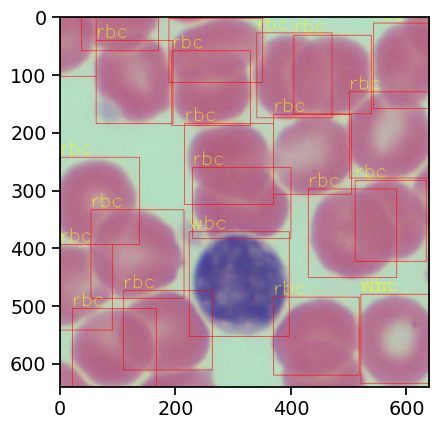

In [25]:
image = draw_image(image_file, label_file, cells_classes)
image = image[:,:,2::-1]
plt.imshow(image)
plt.show()